# Code for AMAS project 1
### *By Niels August Davidsen*

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

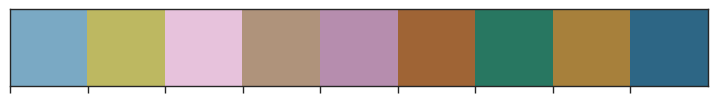

In [8]:
sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")
#sns.set_style("darkgrid", {"axes.facecolor": ".9"})
colors = sns.color_palette('colorblind', 10, desat = 0.5)
colors = colors[::-1]
colors.pop(2)
sns.set_palette(colors)
sns.palplot(colors)



plt.rcParams['axes.grid'] = True
#plt.rcParams['axes.grid.axis'] = 'y'
#plt.rcParams['axes.grid.which'] = 'major'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['figure.dpi'] = 150
plt.style.use('seaborn-v0_8')

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

In [3]:
url_2014 = 'https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2025/data/2014KenPomeroy.html'
url_2009 = 'https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2025/data/2009KenPomeroy.html'

In [19]:

# Send a GET request to the webpage
response = requests.get(url_2014)
response.raise_for_status()  # Ensure the request was successful

# Parse the webpage content
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table using soup (BS4) - Table id is found by inspecting the HTML file of the webpage
table = soup.find('table', {'id': 'ratings-table'})

# Extract table headers
headers = [th.get_text() for th in table.find('thead').find_all('th')]
headers = list(filter(lambda x: x != '', headers))
headers = headers[2:]


for j in range(4):
    if j == 0:
        headers[-(j + 1)] = headers[-(j + 1)] + '_NCOS'
    else:
        headers[-(j + 1)] = headers[-(j + 1)] + '_SoS'


# Finding strings with ONLY integers of length 1, 2 or 3
pattern = re.compile(r'^\d{1,3}$')
reg_city = re.compile(r'\d{1,2}$')

# Extract table rows
rows = []
for row_number,row in enumerate(table.find('tbody').find_all('tr')):
    cells = row.find_all(['th', 'td'])
    cells_text = [cell.get_text() for cell in cells]

    if cells_text[0] == '' or cells_text[0] == ' ':
        continue
    
    # Remove elements in cells_text that concists ONLY of integers of length 1, 2 or 3
    for i, element in enumerate(cells_text):

        if pattern.match(element) and i > 1:
            cells_text.pop(i)

    reg_search = reg_city.search(cells_text[1])
    if reg_search is not None:
        cells_text[1] = cells_text[1][:- ( len(reg_search.group(0) ) + 1 )]

    # Creating an fail-safe for the case where the length of cells_text does not match the length of headers
    if len(cells_text) != len(headers):
        print(len(cells_text), len(headers))
        print(f'Error: Length of cells_text does not match length of headers in row {row_number}')
    
    rows.append(cells_text)



In [5]:
df = pd.DataFrame(rows, columns=headers)                                # Create a DataFrame from the rows
df.to_csv('kenpom_2014_ratings.csv', index=False)                       # Save the DataFrame to a CSV file

display(df)                                                             # Display the DataFrame

,Rk,Team,Conf,W-L,NetRtg,ORtg,DRtg,AdjT,Luck,NetRtg_SoS,ORtg_SoS,DRtg_SoS,NetRtg_NCOS
0,1,Louisville,Amer,31-6,+30.41,118.9,88.5,67.2,-.045,+4.31,107.0,102.7,-4.65
1,2,Arizona,P12,33-5,+30.11,116.5,86.4,62.8,+.014,+9.30,109.9,100.6,+1.62
2,3,Florida,SEC,36-3,+28.57,116.5,88.0,61.3,+.053,+9.02,109.4,100.4,+2.39
3,4,Virginia,ACC,30-7,+26.46,114.8,88.3,59.5,+.012,+8.67,109.4,100.8,+1.57
4,5,Wisconsin,B10,30-8,+25.89,122.0,96.1,62.4,+.019,+11.44,110.2,98.8,+3.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,347,Mississippi Valley St.,SWAC,9-23,-22.93,93.0,115.9,70.9,+.012,-8.65,98.8,107.4,+6.21
355,348,Abilene Christian,Slnd,11-20,-23.35,94.0,117.3,63.2,-.045,-2.67,104.7,107.4,+13.38
356,349,Presbyterian,BSth,6-26,-25.87,94.2,120.0,63.5,-.017,-7.84,101.7,109.6,-7.05
357,350,Grambling St.,SWAC,5-24,-26.60,95.5,122.1,66.0,-.017,-9.05,98.7,107.8,+6.51


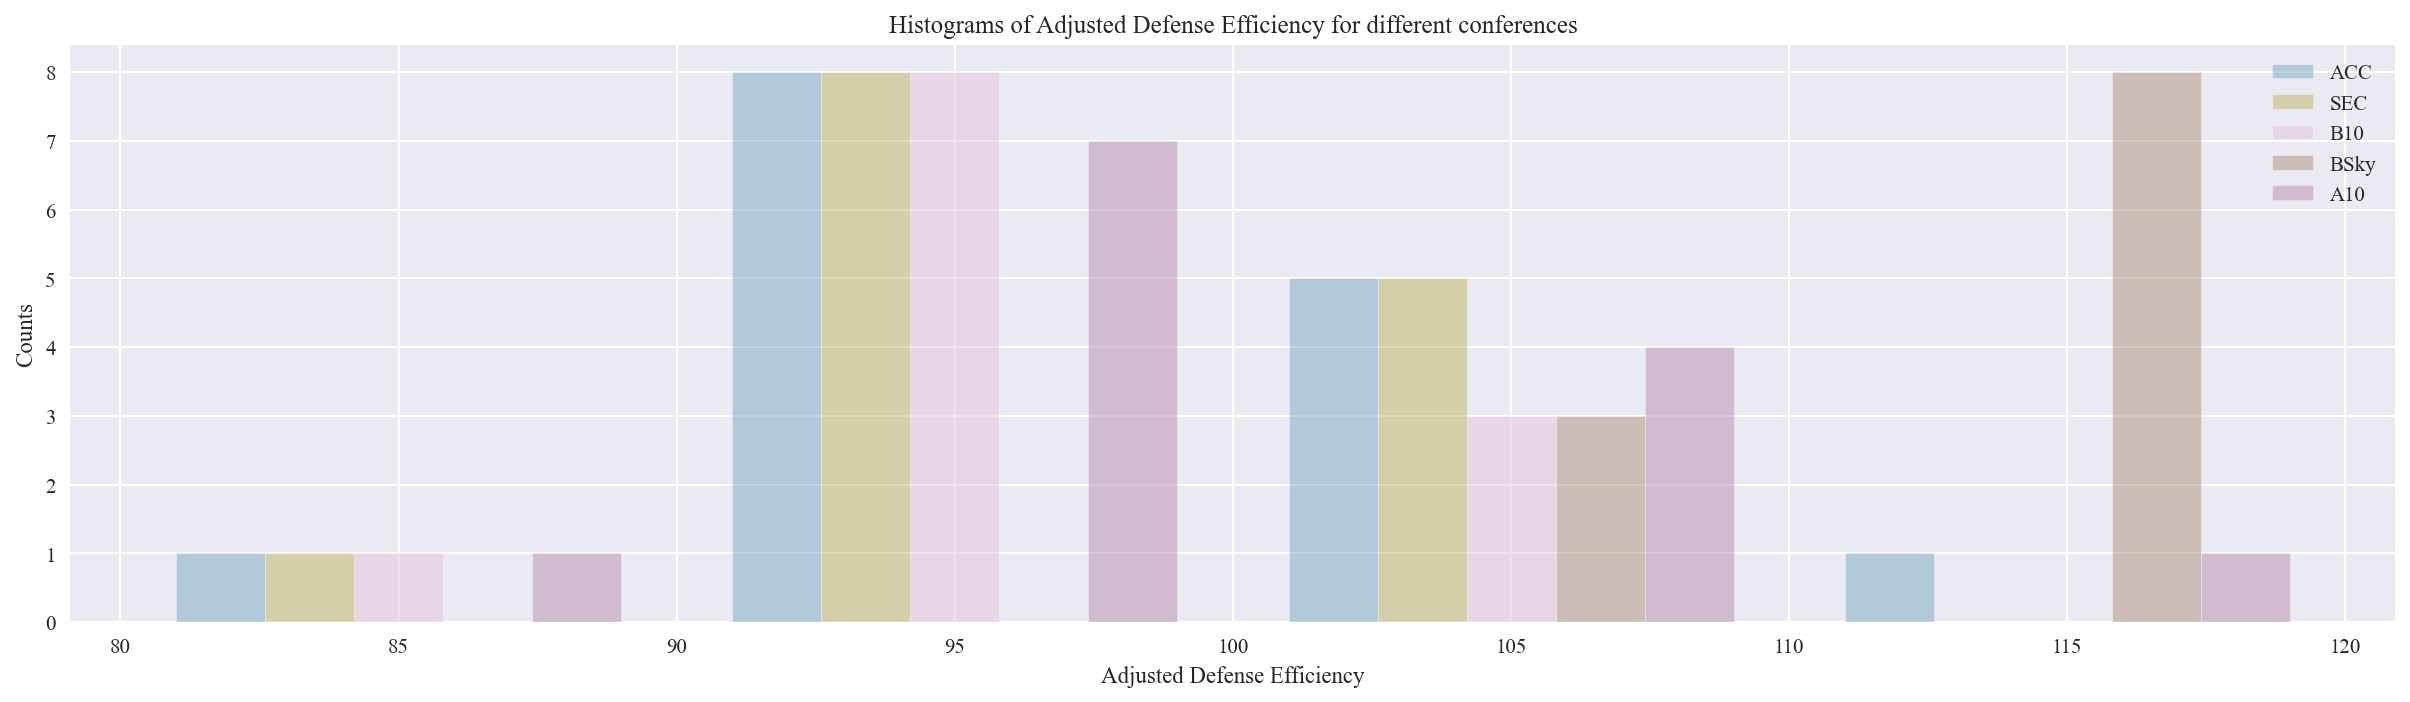

In [ ]:
# Grouping the data into conferences (ACC, SEC, B10, BSky and A10)

conf_names = ['ACC', 'SEC', 'B10', 'BSky', 'A10']
fig_conf, ax_conf = plt.subplots(1, 1, figsize=(20, 5), dpi = 150)
hist_range = [80, 120]
bin_arr = np.arange(80, 130, 10)

hist_data = []

for i, conf in enumerate(conf_names):
    conf_teams = df[df['Conf'] == conf]
    hist_data.append(conf_teams['DRtg'].astype(float))

ax_conf.hist(hist_data, range=hist_range, bins=bin_arr, alpha=0.5, label=conf_names, color = colors[:len(conf_names)])
ax_conf.set_title('Histograms of Adjusted Defense Efficiency for different conferences')
ax_conf.set_xlabel('Adjusted Defense Efficiency')
ax_conf.set_ylabel('Counts')
ax_conf.legend()

In [14]:
acc_teams = df[df['Conf'] == 'ACC']
acc_drtg = acc_teams['DRtg']

acc_drtg.values

array(['88.3', '100.4', '95.0', '93.0', '94.2', '97.4', '95.2', '93.7',
       '102.4', '99.3', '105.8', '99.6', '101.6', '111.8', '100.8'],
      dtype=object)